# Bikes

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
bikes = pd.read_csv("bikes.csv")

X = bikes[["hour", "temperature", "humidity", "windspeed"]]
Y = bikes["count"]

ordered_var_names = ["hour", "temperature", "humidity", "windspeed"]

In [4]:
#With m=50
idatas_m50 = []
trees_m50 = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", Y.std())
        μ = pmb.BART("μ", X[ordered_var_names[:idx+1]], Y, m=50)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(random_seed=RANDOM_SEED)
        idatas_m50.append(idata)
        trees_m50.append(μ)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
/home/alejandro/anaconda3/envs/bart-variables/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


We now check that computing the predictions estimated by pruning the trees is close to the predictions if we actually ommits covariables and refit models

In [5]:
samples = 100
rng = np.random.default_rng(RANDOM_SEED)

In [6]:
predicted_all = pmb.utils._sample_posterior(trees_m50[-1].owner.op.all_trees,
                                            X=X.values,
                                            m=50,
                                            rng=rng,
                                            size=samples)
ev_mean = np.zeros(len(ordered_var_names))
ev_hdi = np.zeros((len(ordered_var_names), 2))

for idx, tree in enumerate(trees_m50):
    predicted_subset = pmb.utils._sample_posterior(tree.owner.op.all_trees,
                                                   X=X[ordered_var_names[:idx+1]].values,
                                                   m=50,
                                                   rng=rng,
                                                   size=samples)
    pearson = np.zeros(samples)
    for j in range(samples):
        pearson[j] = (
            pearsonr(predicted_all[j].flatten(), predicted_subset[j].flatten())[0]
        ) ** 2
    ev_mean[idx] = np.mean(pearson)
    ev_hdi[idx] = az.hdi(pearson)

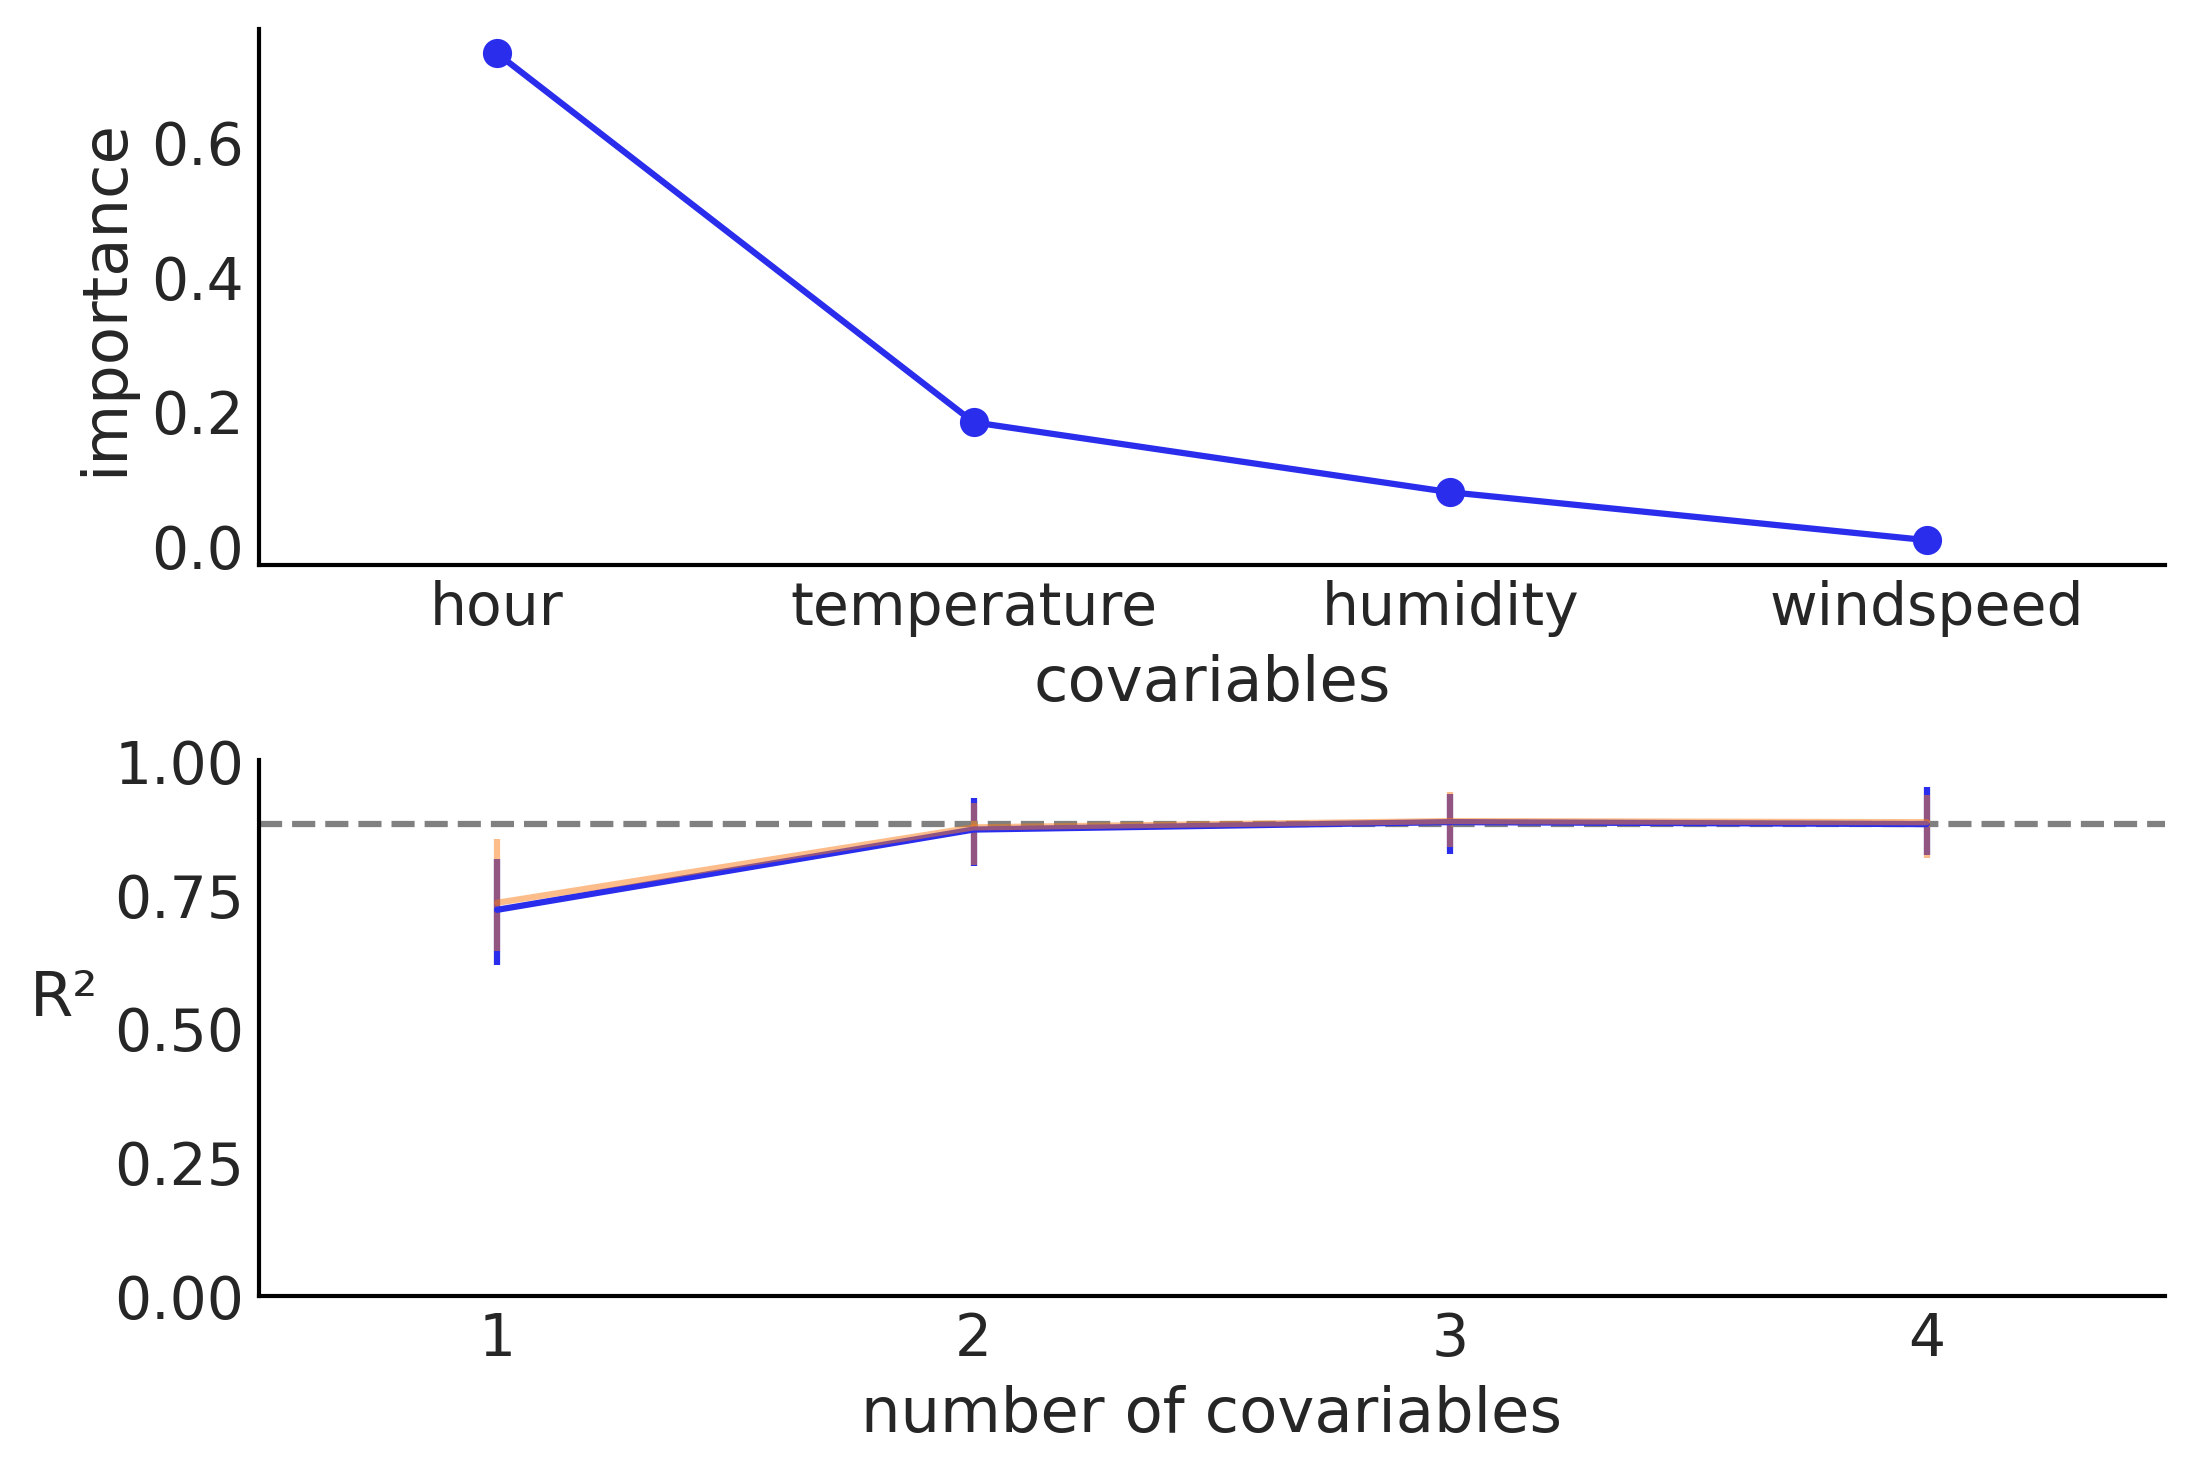

In [7]:
# labels = ["hour", "temperature", "humidity", "windspeed"]
axes = pmb.utils.plot_variable_importance(idatas_m50[-1], trees_m50[-1], X.values,
                                          labels=ordered_var_names,
                                          samples=samples)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(ticks, ev_mean, np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)), alpha=0.5)
plt.savefig("bikes_VI_m50.png");

In [8]:
#With m=200
idatas_m200 = []
trees_m200 = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", Y.std())
        μ = pmb.BART("μ", X[ordered_var_names[:idx+1]], Y, m=200)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(random_seed=RANDOM_SEED)
        idatas_m200.append(idata)
        trees_m200.append(μ)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [9]:
predicted_all = pmb.utils._sample_posterior(trees_m200[-1].owner.op.all_trees,
                                            X=X.values,
                                            m=200,
                                            rng=rng,
                                            size=samples)
ev_mean = np.zeros(len(ordered_var_names))
ev_hdi = np.zeros((len(ordered_var_names), 2))

for idx, tree in enumerate(trees_m200):
    predicted_subset = pmb.utils._sample_posterior(tree.owner.op.all_trees,
                                                   X=X[ordered_var_names[:idx+1]].values,
                                                   m=200,
                                                   rng=rng,
                                                   size=samples)
    pearson = np.zeros(samples)
    for j in range(samples):
        pearson[j] = (
            pearsonr(predicted_all[j].flatten(), predicted_subset[j].flatten())[0]
        ) ** 2
    ev_mean[idx] = np.mean(pearson)
    ev_hdi[idx] = az.hdi(pearson)

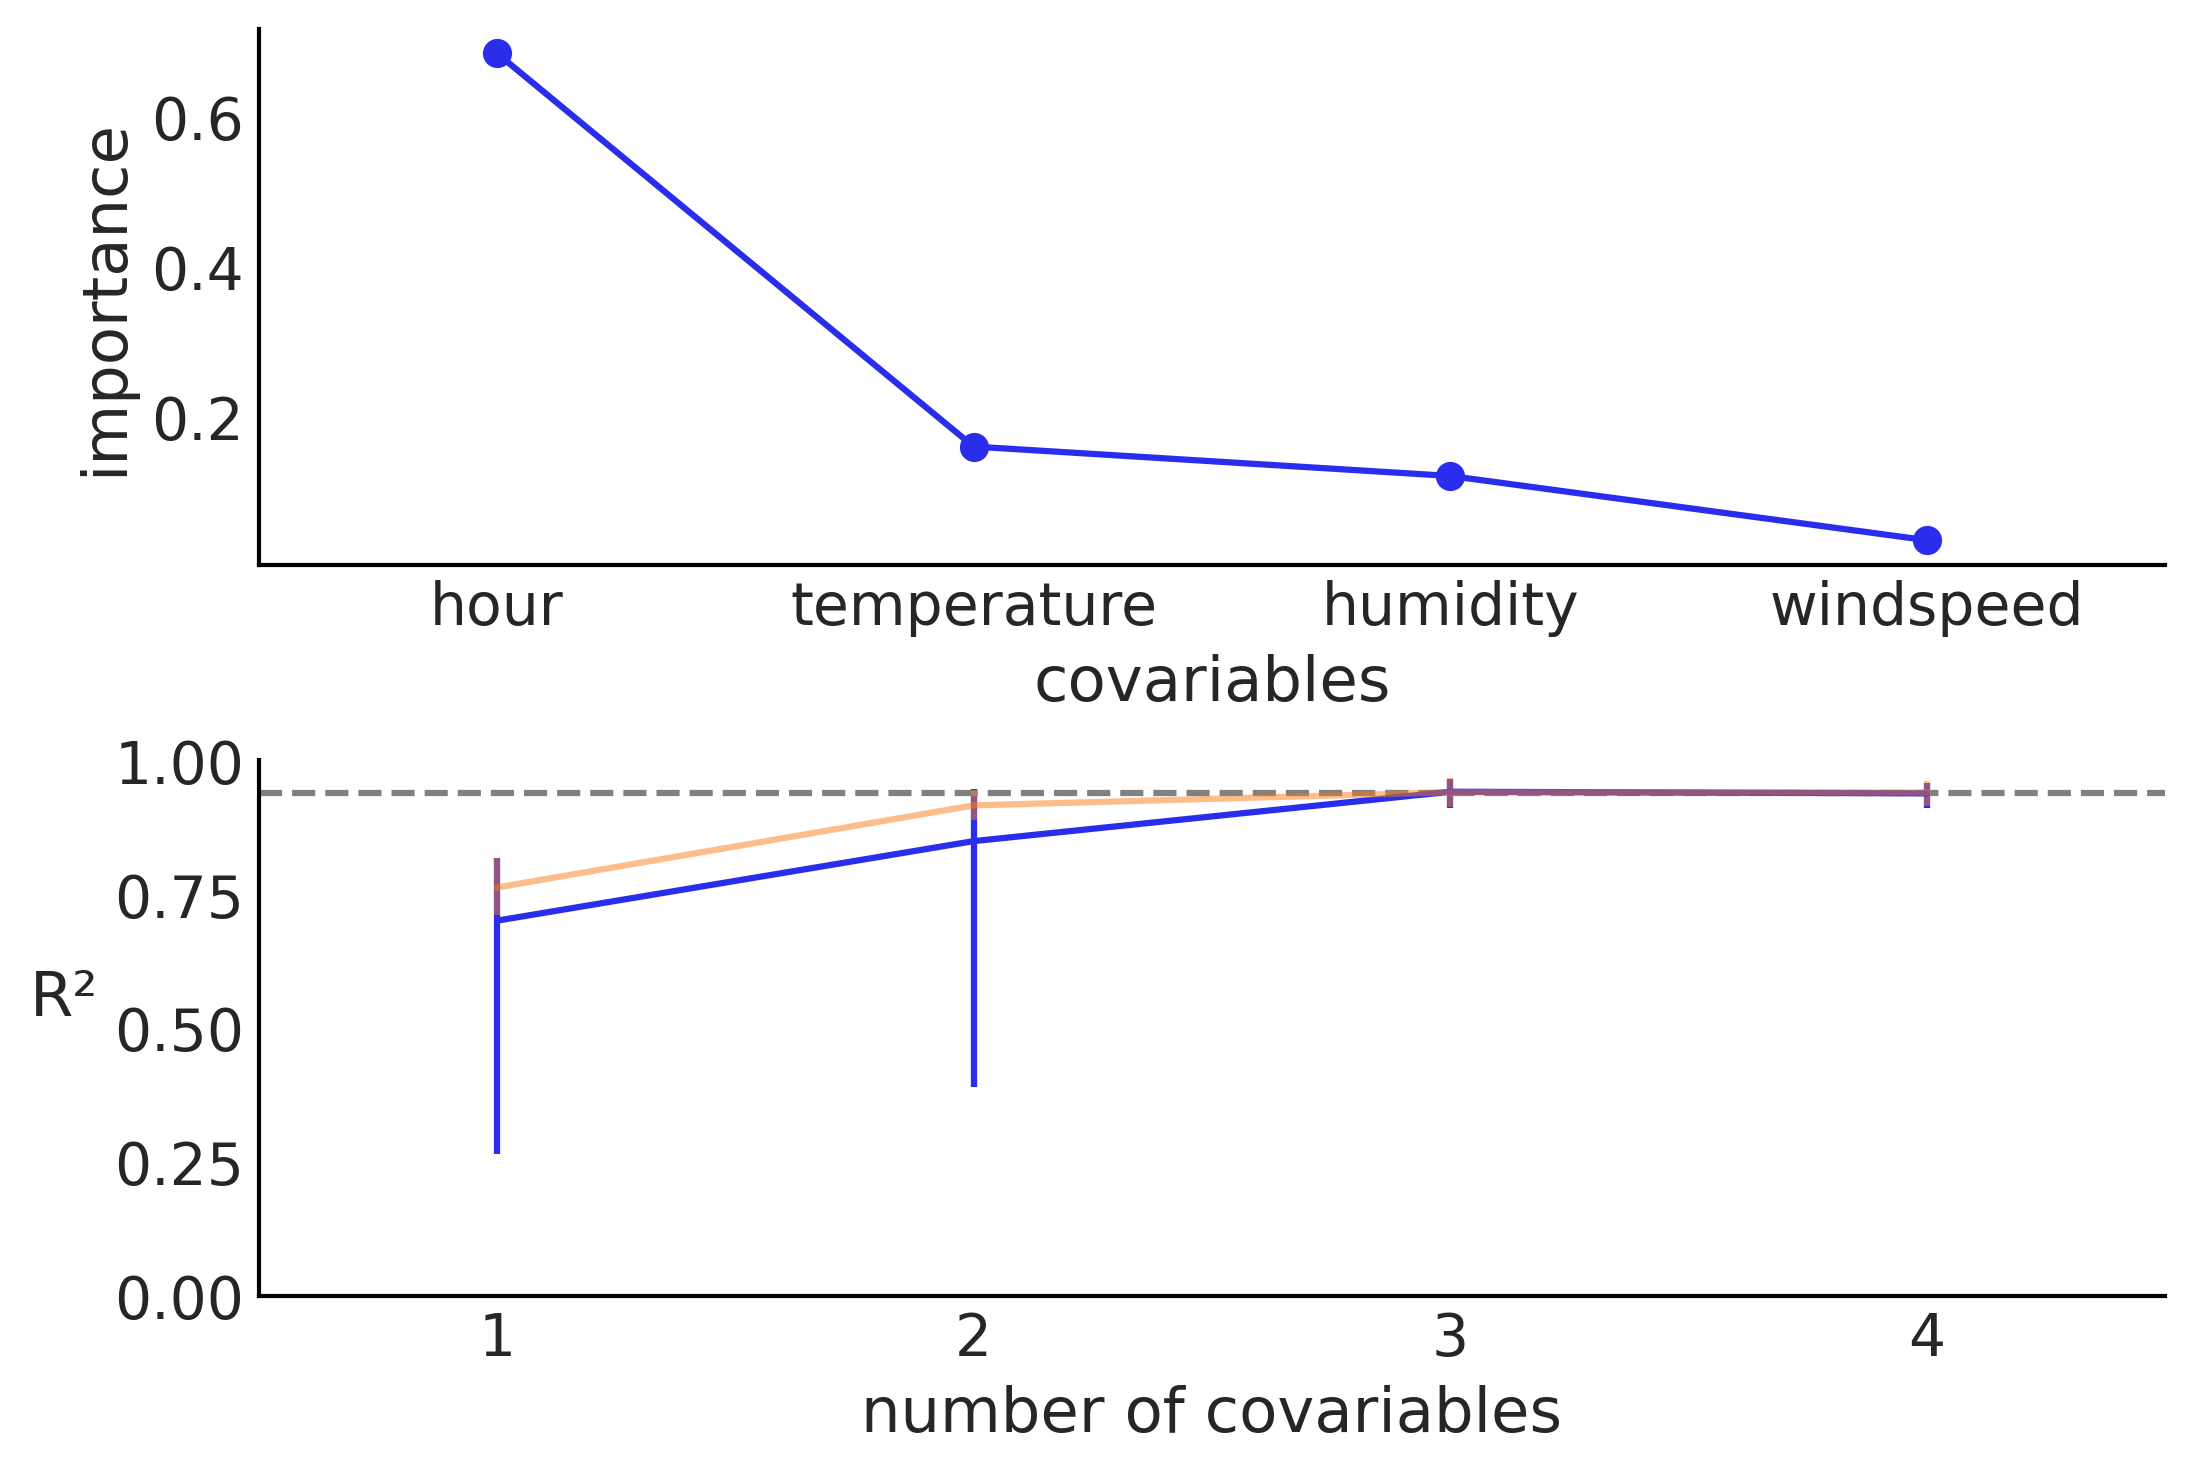

In [10]:
# labels = ["hour", "temperature", "humidity", "windspeed"]
axes = pmb.utils.plot_variable_importance(idatas_m200[-1], trees_m200[-1], X.values,
                                          labels=ordered_var_names,
                                          samples=samples)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(ticks, ev_mean, np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)), alpha=0.5)
plt.savefig("bikes_VI_m200.png");